In [1]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
#%matplotlib notebook
import numpy as np
import pandas as pd
import networkx as nx
import scipy.stats as stats
import matplotlib.pyplot as plt
from nettools.monoplex import NetworkGenerator 
from nettools.multiplex import MultiplexConstructor
from nettools.multiplex import InterMeasures
from nettools.monoplex import CentralityMeasure
from nettools.epidemic import SISMultiplex, SIRMultiplex
from nettools.utils import load_multinet_by_name, NX_CENTRALITY

# Centrality for multiplex synthetic networks
In this notebook I describe centrality measure for *monoplex* and *multiplex* synthetic networks, besides that I will spread disease on each tested network, using seed nodes with greatest centrality score, results will be noted and ploted. My aim is to find best seed node for multiplex networks.

### Reasearch approach
In my reaserch I will test centrality on:
* Aggregated networks
* Weighted Aggregated networks
* Mulitplex Measures

### Synthetic networks used in reaserch
In my work I will use five synthetic networks: 
* **ER-ER** Network
* **ER-BA** Network
* **BA-BB** Network
* **BA-BA** Not correlated Network
* **BA-BA** Correlated Network

In [3]:
avg_deg = 4.0
network_size = 300
ng = NetworkGenerator(network_size)
network_ba_1 = ng.ba_network(m0=int(avg_deg / 2))
network_ba_2 = ng.ba_network(m0=int(avg_deg / 2))
network_er_1 = ng.er_network(p=(avg_deg / network_size))
network_er_2 = ng.er_network(p=(avg_deg / network_size))
network_bb_1 = ng.bb_network(m0=int(avg_deg / 2))

Define network constructor and create correlated network for **BA** Network.

In [4]:
mc = MultiplexConstructor()
network_corr_ba_1 = mc.rewire_hubs(network_ba_1, rsteps=5000)

Create multiplex networks.

In [5]:
multi_erer = mc.construct(network_er_1, network_er_2)
multi_erba = mc.construct(network_er_2, network_ba_1)
multi_babb = mc.construct(network_ba_1, network_bb_1)
multi_baba_nc = mc.construct(network_ba_2, network_ba_1)
multi_baba_corr = mc.construct(network_ba_1, network_corr_ba_1)

After preparing 5 networks for test, create 2 single layer networks for veryfication

In [6]:
network_ba_single = ng.ba_network(m0=int(avg_deg / 2))
network_er_single = ng.er_network(p=(avg_deg / network_size))

## Centrality for monoplex network
In first step I decided to examine centrality on monoplex graph with same properties as networks in multilayer graph.
In first test **ER** Network will be used, I will calculate centrality and then disease will be spreaded by some central nodes. <br>
To find best method for **centrality** calculation I used method used in *Identyfying a set of influential spreaders in complex networks*, in which number of nodes *infected* and *recovered* are added and compared, with this archived by other methods in steady state.
$$F(t)  = \frac{n_i(t) + n_r(t)}{n}$$
Centrality is examined for 50 different realisation, in each realisation new network is generated.

### Erdos-Renyi Network

In [7]:
for idx, method in enumerate(NX_CENTRALITY.keys()):
        avg_results = np.zeros((50, 50))
        for n_time in range(0, 50):
            ba_net = ng.ba_network(m0=2)
            mn = mc.construct(ba_net)
            cn = CentralityMeasure(ba_net.network)
            results_cn = cn.network_cn(method)
            if method == 'hits':
                results_cn = results_cn[1]
            best_nodes = sorted(results_cn.items(), key=lambda x: x[1])[::-1]
            sir = SIRMultiplex(mn, beta=0.3, mu=0.1, inter_beta=0.0, inter_rec=0.0, seed_nodes=[best_nodes[0][0]])
            result_sir = sir.run(epochs=50, visualize=False, layers=[0], labels=True, pause=2)
            avg_results[n_time] = np.array(result_sir)
        plt.plot(np.mean(avg_results, axis=0), hold=True, label=method)
plt.legend()
plt.show(True)

<center><h3>Zoomed result plot for spreading disease for SIR model</h3></center><br>
<img src="images/plot_sir_er_1.png", width=400, height=400></img>
<img src="images/plot_sir_er_2.png", width=400, height=400></img>

First plots picture spreading efficiency, where specific epidemic threshold for random networks can be seen. High epidemic threshold is coused due to network characteristic and this phenoemnon is widely examined by percolation. 

<img src="images/plot_sir_er_1_zoom.png", width=400, height=400></img>
<img src="images/plot_sir_er_2_zoom.png", width=400, height=400></img>
<img src="images/plot_sir_er_3_zoom.png", width=400, height=400></img>


As we can see *voterank*, *pagerank* and *closeness* are best centrality metrics for each realisation on **ER** Network.
*Betweeness* and *k-shell* algorithms have the lowest scores.

After centrality metrics investigation, I run disease **10 epochs** disease on each node and examine **disease efficiency** and **node centrality score**. First I plot disease efficiency for each node, sorted by decreasing centrality score, next I plot correlation between centrality and disease efficiency.

In [33]:
cent_dict_er = {}
cent_val_er = {}
cent_dict_er_15 = {}
cm_er = CentralityMeasure(network_er_single.network)
for method in NX_CENTRALITY.keys():
    if method == 'supernode':
        continue
    results = cm_er.network_cn(method)
    if method == 'hits':
        results = results[1]
    best_nodes = sorted(results.items(), key=lambda x: x[1])[::-1]
    cent_val_er[method] = sorted(results.values())[::-1]
    cent_dict_er[method] = [cnt[0] for cnt in best_nodes]
    cent_dict_er_15[method] = [cnt[0] for cnt in best_nodes[:15]]

Spread disease on **ER** Network. After computing centrality scores for each node we can use it to begin disease.

In [12]:
scores = {}
scores_15 = {}
mean_realisation = 10
for method, nodes in cent_dict_er.items():
    node_labels = []
    nodes_scores = []
    for node in nodes:
        mean_spread = []
        for _ in range(mean_realisation):
            sis = SIRMultiplex(mc.construct(network_er_single), beta=0.3, mu=0.1, inter_beta=0.0, 
                               inter_rec=0.0, seed_nodes=[node])
            sis.run(epochs=10, visualize=False)
            mean_spread.append(sis.get_num('i') + sis.get_num('r'))
        node_labels.append(node)
        nodes_scores.append(np.mean(mean_spread))
    scores[method] = node_labels, nodes_scores
    scores_15[method] = nodes_scores[:15]
pd.DataFrame.from_dict(scores_15)

,betweenness,closeness,degree,eigenvector,hits,k-shell,pagerank,voterank
0,138.6,135.9,145.6,145.4,148.6,94.8,156.3,124.3
1,161.4,155.5,114.5,168.5,163.8,44.6,120.2,146.1
2,150.0,156.5,140.2,112.4,123.1,1.0,149.9,123.8
3,123.2,142.5,113.8,151.0,140.6,107.5,87.5,117.7
4,120.4,137.8,112.7,130.2,125.1,75.6,125.3,131.7
5,106.0,129.0,112.7,160.1,155.2,33.1,141.5,118.0
6,98.6,134.9,137.4,114.3,115.9,109.5,137.4,125.7
7,139.2,139.5,84.1,154.1,146.5,1.0,129.6,139.1
8,155.4,145.3,92.0,168.5,157.7,1.0,78.2,133.1
9,17.6,133.9,47.2,140.5,124.6,100.0,139.6,66.9


Having centrality scores and spreading efficiency. I plot rolling mean for spreading efficiency to find how disease spread for each node *[based on centrality - nodes are sorted using centrality score]* 
Using this plots we can find spreading efficiency trend when using proper nodes.

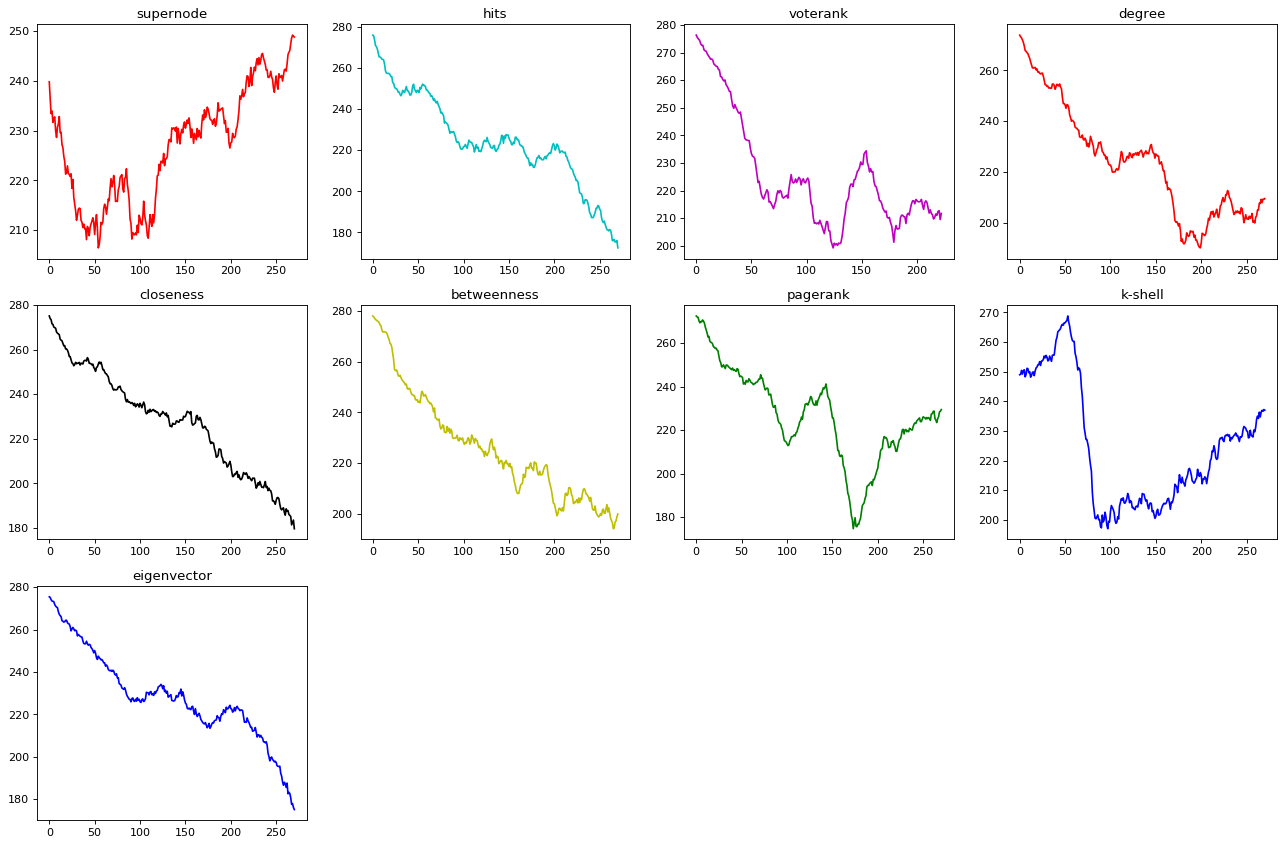

In [75]:
def running_mean(x, nnodes):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[nnodes:] - cumsum[:-nnodes]) / nnodes

idx_counter = 1
colors = "bgrcmrkygbb"
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
plt.subplots_adjust(top=1.5)
for method, nd_lab_scores in scores.items():
    sp = plt.subplot(840 + idx_counter)
    sp.plot(running_mean(nd_lab_scores[1], 30), colors[idx_counter + 1])
    sp.set_title(method)
    idx_counter += 1
plt.show()

In next step I plot centrality score with spreading efficiency, moreover I compute **Kendal Correlation** for each plots.

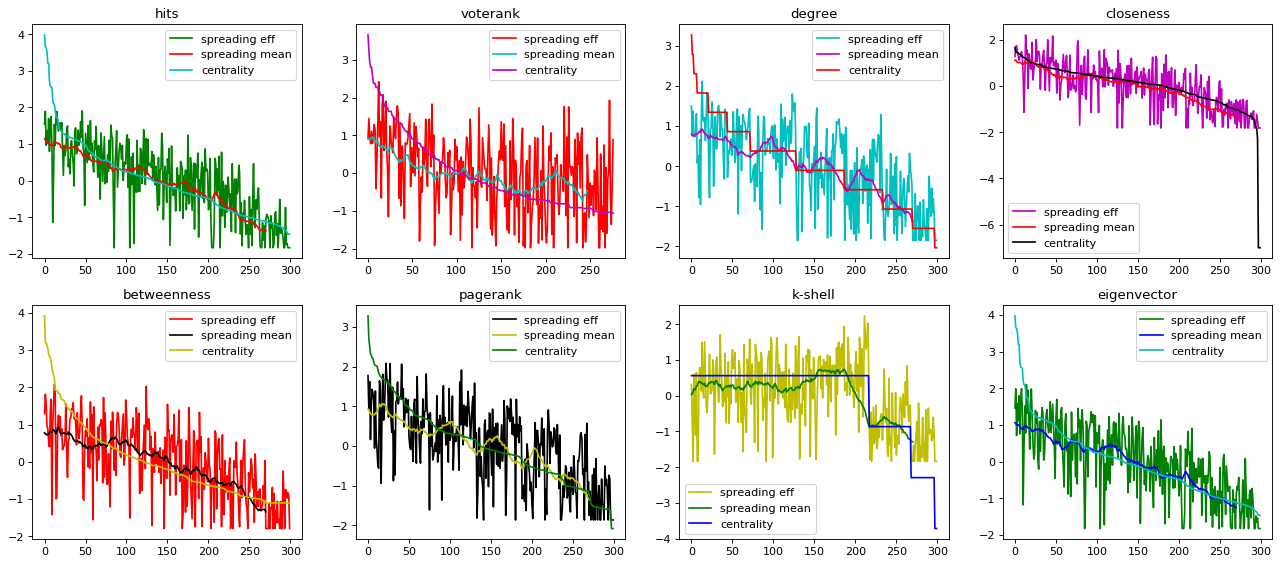

Kendal Correlation


,betweenness,closeness,degree,eigenvector,hits,k-shell,pagerank,voterank
0,0.470898,0.532825,0.513538,0.533637,0.57436,0.490617,0.458289,0.275003


In [57]:
def running_mean(x, nnodes):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[nnodes:] - cumsum[:-nnodes]) / nnodes

idx_counter = 1
corr_kendal = {}
colors = "bgrcmrkygbc"
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
plt.subplots_adjust(top=1.5)
for method, nd_lab_scores in scores.items():
    normalized_spread = (np.array(nd_lab_scores[1]) - np.mean(nd_lab_scores[1])) / np.std(nd_lab_scores[1])
    normalized_cent = (cent_val_er[method] - np.mean(cent_val_er[method])) / np.std(cent_val_er[method])
    sp = plt.subplot(840 + idx_counter)
    sp.plot(normalized_spread, colors[idx_counter], label="spreading eff")
    sp.plot(running_mean(normalized_spread, 30), colors[idx_counter + 1], label="spreading mean")
    sp.plot(normalized_cent, colors[idx_counter + 2], label="centrality")
    sp.legend()
    tau, p_value = stats.kendalltau(
                    nd_lab_scores[1],
                    cent_val_er[method]
                )
    corr_kendal[method] = [tau]
    sp.set_title(method)
    idx_counter += 1
plt.show()
print("Kendal Correlation")
pd.DataFrame.from_dict(corr_kendal)

### Barabassi - Albert Network

In next step I will examine spreading on **BA** Network. Desired behaviour is that **BA** Network will be better spreader than **ER** Network.

<center><h3>Zoomed result plot for spreading disease for SIR model</h3></center><br>
<img src="images/plot_sir_ba_1_zoom.png", width=400, height=400></img>
<img src="images/plot_sir_ba_2_zoom.png", width=400, height=400></img>
<img src="images/plot_sir_ba_4_zoom.png", width=400, height=400></img>

As we can see network architecture matters a lot, we can't just say that one metric is better then another, each metric is different in different network architecture, eg. *degree* have better results for **ER** networks, but analysing both network architectures we can find common patterns.<br>

K-shell have bad spreading efficiency for all examined network architectures and prameters.

After ealier reaserch I found that ealier experiments not fully describe centrality algorithms performance, becouse each spreading is random process and each realisation differ. To summarize I decided for one more experiment. 
In this experiment I loop 50 times over process, in which I generate new network **BA** or **ER**, calculate centrality for each node and start disease 50 times, next take mean over this results.
Using this mean I vote for each network.<br><br>
*Pseudocode*:<br>
*for each method...*<br>
**loop 50 times:**<br>
$\qquad$**create new network**<br>
$\qquad$**compute centrality**<br>
$\qquad$**loop 50 times:** <br>
$\qquad$$\qquad$**spread disease**<br>
$\qquad$**compute mean**<br>
**Take spreading efficiency values
  for earlier defined points (5, 10, 20, 30, 40)**<br>
**vote for methods using rule: 1st-9points, 2st-8points, ...**<br>
**Normalize results**<br><br>

Reasearch results: <br>
Centrality methods scores for points 5, 10, 20, 30. Network: **ER**.
<img src="images/plot_50_er_5_10_20_30_excel.PNG", width=400, height=400></img>
Centrality methods scores for points 5, 10, 20, 30. Network: **ER**. **[Same]**
<img src="images/plot_50_er_5_10_20_30_excel_2.PNG", width=400, height=400></img>
Centrality methods scores for points 30, 40. Network: **ER**. **[Steady-state]**
<img src="images/plot_50_er_30_40_excel.PNG", width=400, height=400></img>
Centrality methods scores for points 5, 10, 20, 30. Network: **BA**. **[Steady-state]**
<img src="images/plot_50_ba_5_10_30_40_excel.PNG", width=400, height=400></img>
Centrality methods scores for points 5, 10, 20, 30. Network: **BA**.  **[Same]**
<img src="images/plot_50_ba_5_10_30_40_excel_2.PNG", width=400, height=400></img>

Same as ealier we don't have clear answer but on this bar charts we can see that for each networks and points, we can find metrics with +- very good score, very bad score and neutral, which score differs and depends on network architecure *[degree]*.

**Best Metrics** seems to be: 
* hits
* eigenvector
* closeness

**Neutral Metrics** 
* degree
* pagerank
* voterank
* superspreader
* betweenness

**Worst Metrics**:
* k-shell

As It was said in *voterank* paper, voterank is better than normal Pagerank.
Despite bad results here, supernode algorithm gives very good results on steady-state for **BA** Network ~94%, It gives also good results for many spreaders.

In [69]:
cent_dict_ba = {}
cent_val_ba = {}
cent_dict_ba_15 = {}
cm_ba = CentralityMeasure(network_ba_single.network)
for method in NX_CENTRALITY.keys():
    results = cm_ba.network_cn(method)
    if method == 'hits':
        results = results[1]
    best_nodes = sorted(results.items(), key=lambda x: x[1])[::-1]
    cent_val_ba[method] = sorted(results.values())[::-1]
    cent_dict_ba[method] = [cnt[0] for cnt in best_nodes]
    cent_dict_ba_15[method] = [cnt[0] for cnt in best_nodes[:15]]

In [64]:
scores = {}
scores_15 = {}
mean_realisation = 10
for method, nodes in cent_dict_ba.items():
    node_labels = []
    nodes_scores = []
    for node in nodes:
        mean_spread = []
        for _ in range(mean_realisation):
            sis = SIRMultiplex(mc.construct(network_ba_single), beta=0.3, mu=0.1, inter_beta=0.0, 
                               inter_rec=0.0, seed_nodes=[node])
            sis.run(epochs=10, visualize=False)
            mean_spread.append(sis.get_num('i') + sis.get_num('r'))
        node_labels.append(node)
        nodes_scores.append(np.mean(mean_spread))
    scores[method] = node_labels, nodes_scores
    scores_15[method] = nodes_scores[:15]
pd.DataFrame.from_dict(scores_15)

,betweenness,closeness,degree,eigenvector,hits,k-shell,pagerank,supernode,voterank
0,286.5,286.0,286.0,287.1,286.1,272.5,285.7,285.2,282.3
1,284.8,283.3,285.0,284.6,280.9,231.2,283.0,275.6,283.3
2,284.5,285.7,281.9,282.8,284.1,264.7,282.9,258.9,283.2
3,280.9,283.9,287.2,281.5,284.6,240.9,284.9,258.3,284.7
4,282.5,282.0,282.7,283.9,279.9,249.7,252.0,231.2,258.4
5,284.6,283.3,284.3,285.5,284.8,278.6,283.5,226.2,278.5
6,281.4,282.2,281.2,282.8,283.7,251.7,255.0,266.5,278.0
7,278.8,280.7,277.7,285.1,281.9,208.5,285.7,232.1,284.4
8,282.1,280.7,284.1,281.7,282.8,212.0,276.7,159.2,274.7
9,285.0,275.4,272.5,279.5,282.4,238.2,284.7,168.9,275.2


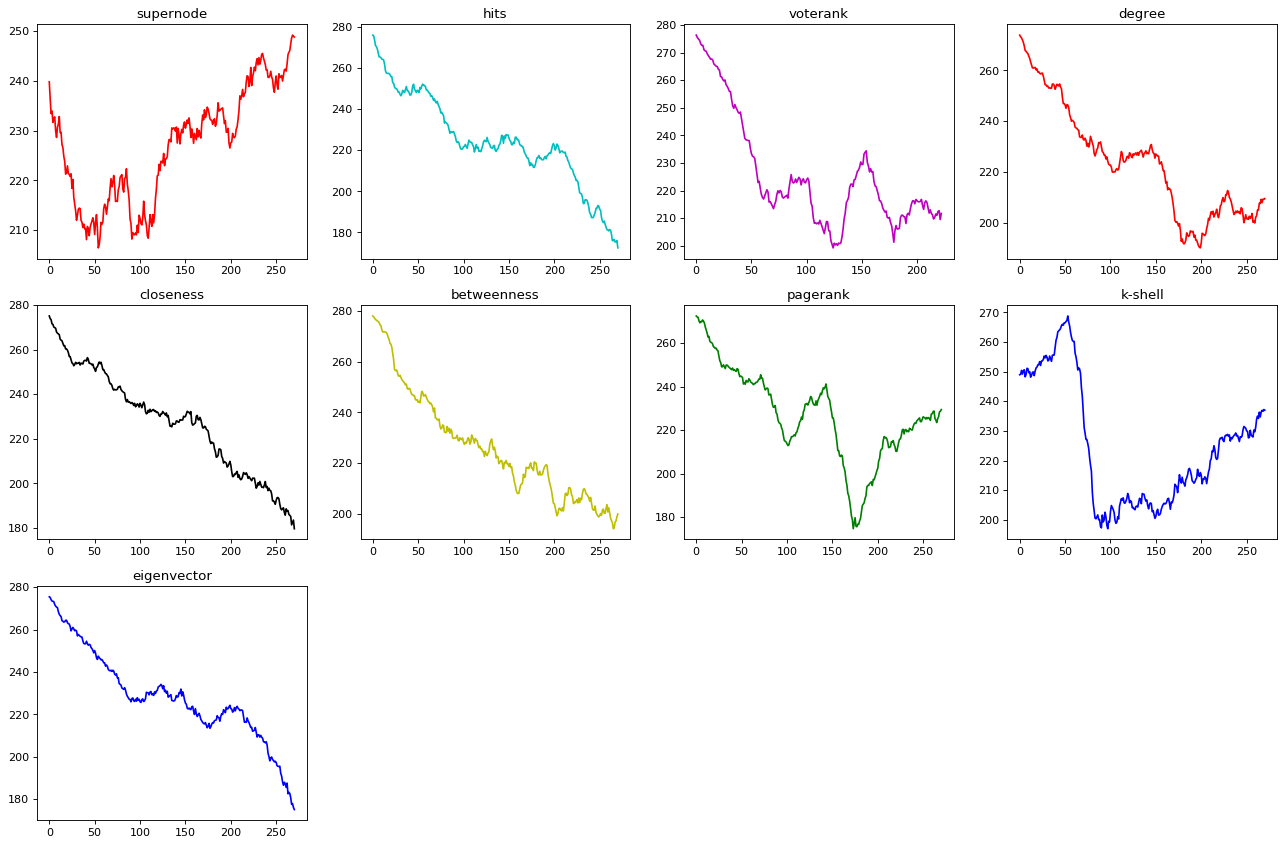

In [65]:
def running_mean(x, nnodes):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[nnodes:] - cumsum[:-nnodes]) / nnodes

idx_counter = 1
colors = "bgrcmrkygbb"
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
plt.subplots_adjust(top=1.5)
for method, nd_lab_scores in scores.items():
    sp = plt.subplot(840 + idx_counter)
    sp.plot(running_mean(nd_lab_scores[1], 30), colors[idx_counter + 1])
    sp.set_title(method)
    idx_counter += 1
plt.show()

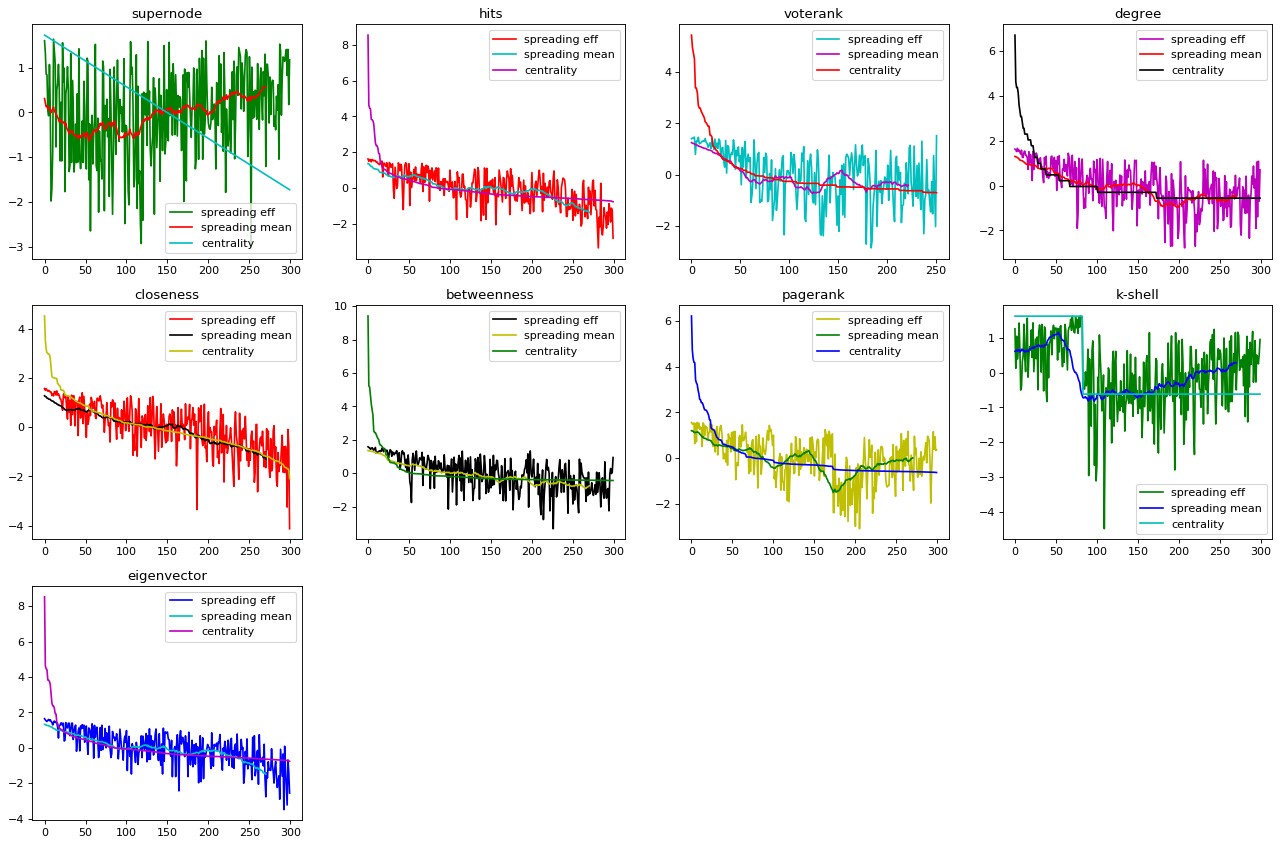

Kendal Correlation


,betweenness,closeness,degree,eigenvector,hits,k-shell,pagerank,supernode,voterank
0,0.475024,0.568857,0.524043,0.527833,0.52892,0.458712,0.305892,-0.160702,0.380135


In [73]:
def running_mean(x, nnodes):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[nnodes:] - cumsum[:-nnodes]) / nnodes

idx_counter = 1
corr_kendal = {}
colors = "bgrcmrkygbcmgrc"
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
plt.subplots_adjust(top=1.5)
for method, nd_lab_scores in scores.items():
    normalized_spread = (np.array(nd_lab_scores[1]) - np.mean(nd_lab_scores[1])) / np.std(nd_lab_scores[1])
    normalized_cent = (cent_val_ba[method] - np.mean(cent_val_ba[method])) / np.std(cent_val_ba[method])
    sp = plt.subplot(840 + idx_counter)
    sp.plot(normalized_spread, colors[idx_counter], label="spreading eff")
    sp.plot(running_mean(normalized_spread, 30), colors[idx_counter + 1], label="spreading mean")
    sp.plot(normalized_cent, colors[idx_counter + 2], label="centrality")
    sp.legend()
    tau, p_value = stats.kendalltau(
                    nd_lab_scores[1],
                    cent_val_ba[method]
                )
    corr_kendal[method] = [tau]
    sp.set_title(method)
    idx_counter += 1
plt.show()
print("Kendal Correlation")
pd.DataFrame.from_dict(corr_kendal)

## Centrality for aggregated network
In second step network centrality will be examined using aggregated networks. 

In [7]:
agg_net_erer = InterMeasures.aggregate(multi_erer.network)
agg_net_erba = InterMeasures.aggregate(multi_erba.network)
agg_net_babb = InterMeasures.aggregate(multi_babb.network)
agg_net_baba_nc = InterMeasures.aggregate(multi_baba_nc.network)
agg_net_baba_corr = InterMeasures.aggregate(multi_baba_corr.network)

### ER-ER Network
First centrality score for each node is computed, in next step this score will be used to begin epidemy.

In [13]:
cent_dict_erer = {}
cent_dict_erer_15 = {}
cm_erer = CentralityMeasure(agg_net_erer)
for method in NX_CENTRALITY.keys():
    results = cm_erer.network_cn(method)
    if method == 'hits':
        results = results[1]
    best_nodes = sorted(results.items(), key=lambda x: x[1])[::-1]
    cent_dict_erer[method] = [cnt[0] for cnt in best_nodes]
    cent_dict_erer_15[method] = [cnt[0] for cnt in best_nodes[:15]]
pd.DataFrame.from_dict(cent_dict_erer_15)

,betweenness,closeness,degree,eigenvector,hits,k-shell,pagerank,supernode,voterank
0,45,45,166,166,166,299,45,103,45
1,246,166,45,100,100,298,166,289,166
2,166,85,246,45,45,297,246,113,246
3,271,258,103,258,258,296,103,262,100
4,103,246,100,103,103,294,100,221,103
5,194,100,271,13,13,293,194,166,194
6,85,103,194,246,246,292,271,31,271
7,209,80,277,80,80,291,277,108,270
8,277,284,270,85,85,289,186,65,125
9,125,271,258,284,284,286,125,100,277


#### Epidemy on ER-ER Network
When we have centrality score for each node, It's possible to calculate spreading for each node.
To calculate spreading I using *SIS* Network, with parameters: 
$$\beta = 0.3$$ $$\mu = 0.01$$ $$\beta_{inter}=0.75$$ $$\mu_{inter} = 0.75$$

In [14]:
scores = {}
scores_15 = {}
mean_realisation = 10
for method, nodes in cent_dict_erer.items():
    node_labels = []
    nodes_scores = []
    for node in nodes:
        mean_spread = []
        for _ in range(mean_realisation):
            sis = SISMultiplex(multi_erer.network, beta=0.3, mu=0.01, inter_beta=0.75, 
                               inter_rec=0.75, seed_nodes=[node])
            sis.run(epochs=10, visualize=False)
            mean_spread.append(sis.get_num('i'))
        node_labels.append(node)
        nodes_scores.append(np.mean(mean_spread))
    scores[method] = node_labels, nodes_scores
    scores_15[method] = nodes_scores[:15]
pd.DataFrame.from_dict(scores_15)

,betweenness,closeness,degree,eigenvector,hits,k-shell,pagerank,supernode,voterank
0,239.3,223.7,183.4,219.6,186.9,81.7,244.8,205.5,249.4
1,213.3,217.0,229.6,182.1,204.4,142.9,166.1,96.8,204.4
2,204.4,206.8,199.0,236.5,240.6,52.3,224.5,171.3,184.9
3,169.7,164.8,165.9,143.0,133.5,81.2,193.9,123.2,202.8
4,195.8,214.5,165.0,142.3,172.0,179.7,204.6,117.4,182.9
5,160.0,177.6,188.1,251.7,241.5,116.4,134.8,220.0,171.2
6,199.2,156.5,160.1,200.2,214.2,82.0,226.2,201.7,183.5
7,140.8,209.6,101.6,250.3,240.9,164.5,143.3,69.1,202.4
8,170.6,130.1,194.1,221.5,214.6,100.6,176.7,85.2,107.3
9,146.1,162.6,188.8,77.5,152.3,185.2,195.7,217.0,133.3


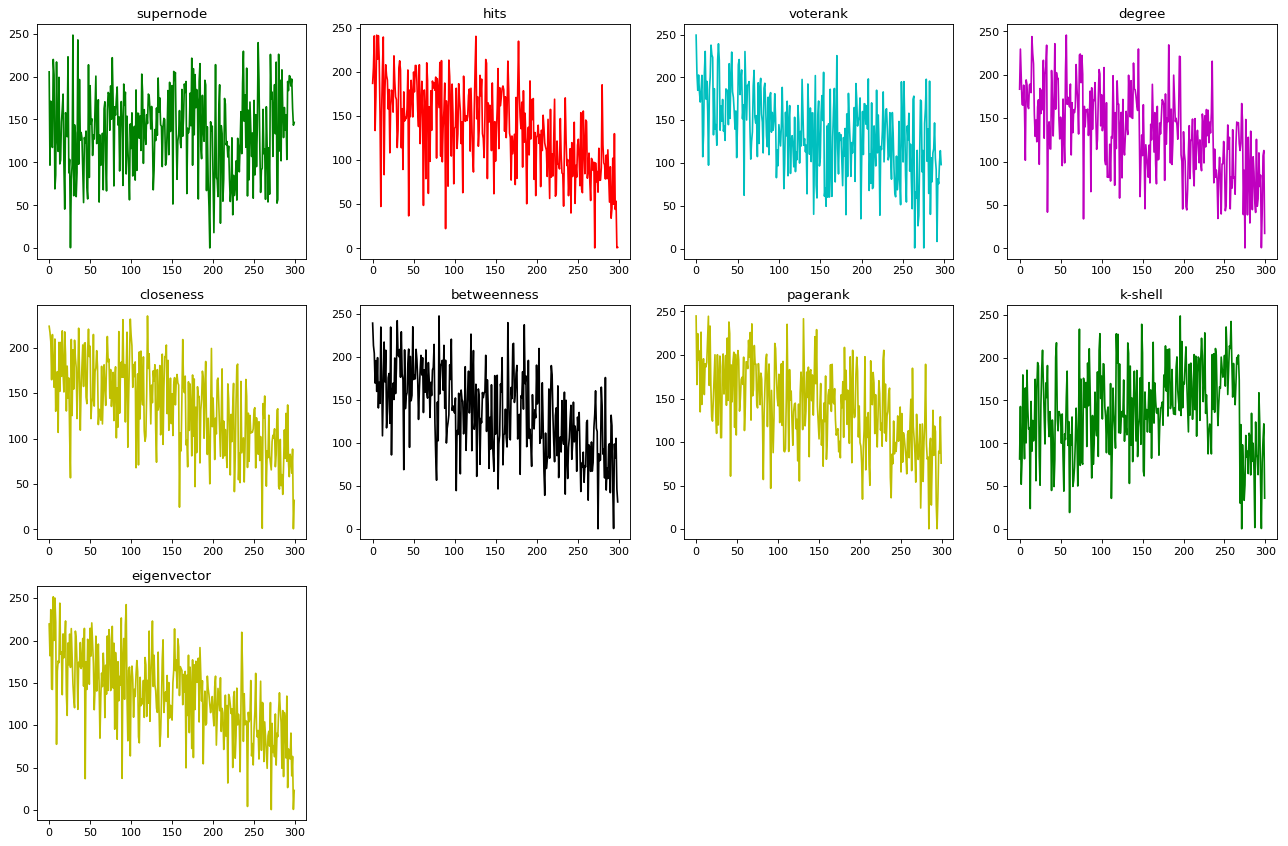

In [15]:
idx_counter = 1
colors = "bgrcmykygyb"
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
plt.subplots_adjust(top=1.5)
for method, nd_lab_scores in scores.items():
    sp = plt.subplot(840 + idx_counter)
    sp.plot(nd_lab_scores[1], colors[idx_counter])
    sp.set_title(method)
    idx_counter += 1
plt.show()

### BA-BA Network
Centrality scores for Barabassi Albert network.

In [17]:
cent_dict_baba = {}
cent_dict_baba_15 = {}
cm_baba = CentralityMeasure(agg_net_baba_nc)
for method in NX_CENTRALITY.keys():
    results = cm_baba.network_cn(method)
    if method == 'hits':
        results = results[1]
    best_nodes = sorted(results.items(), key=lambda x: x[1])[::-1]
    cent_dict_baba[method] = [cnt[0] for cnt in best_nodes]
    cent_dict_baba_15[method] = [cnt[0] for cnt in best_nodes[:15]]
pd.DataFrame.from_dict(cent_dict_baba_15)

,betweenness,closeness,degree,eigenvector,hits,k-shell,pagerank,supernode,voterank
0,175,3,175,175,175,283,175,0,175
1,3,175,3,3,3,259,3,9,3
2,1,1,1,1,1,258,1,20,1
3,199,0,6,0,0,255,6,31,6
4,6,199,199,6,6,241,199,240,199
5,0,6,0,199,199,237,0,224,7
6,7,7,7,4,4,199,7,7,12
7,5,4,4,7,7,183,4,131,5
8,4,5,12,2,2,175,8,62,4
9,10,10,8,5,5,174,12,290,8


#### Epidemy on BA-BA Network
When we have centrality score for each node, It's possible to calculate spreading for each node.
To calculate spreading I using *SIS* Network, with parameters: 
$$\beta = 0.3$$ $$\mu = 0.01$$ $$\beta_{inter}=0.75$$ $$\mu_{inter} = 0.75$$

In [19]:
scores = {}
scores_15 = {}
mean_realisation = 10
for method, nodes in cent_dict_baba.items():
    node_labels = []
    nodes_scores = []
    for node in nodes:
        mean_spread = []
        for _ in range(mean_realisation):
            sis = SISMultiplex(multi_baba_nc.network, beta=0.3, mu=0.01, inter_beta=0.75, 
                               inter_rec=0.75, seed_nodes=[node])
            sis.run(epochs=10, visualize=False)
            mean_spread.append(sis.get_num('i'))
        node_labels.append(node)
        nodes_scores.append(np.mean(mean_spread))
    scores[method] = node_labels, nodes_scores
    scores_15[method] = nodes_scores[:15]
pd.DataFrame.from_dict(scores_15)

,betweenness,closeness,degree,eigenvector,hits,k-shell,pagerank,supernode,voterank
0,335.6,340.4,329.7,328.7,335.2,289.7,329.5,341.8,327.7
1,341.2,325.2,341.0,340.2,342.6,327.9,344.3,340.5,341.9
2,339.8,340.3,340.7,336.8,339.1,339.5,338.3,335.0,340.7
3,334.0,339.4,343.1,338.1,333.2,337.5,338.0,304.0,341.8
4,338.1,334.7,333.2,336.2,342.2,327.4,334.7,333.2,329.6
5,336.1,339.3,339.3,338.8,333.5,336.1,338.3,257.2,334.4
6,341.7,334.1,336.8,341.3,341.6,335.8,345.1,336.0,333.8
7,337.7,336.3,342.7,340.2,339.3,333.3,345.3,342.7,340.4
8,346.5,335.7,342.5,341.8,344.6,329.8,342.4,323.8,345.0
9,335.5,335.5,340.6,344.9,338.7,331.6,336.2,271.7,344.5


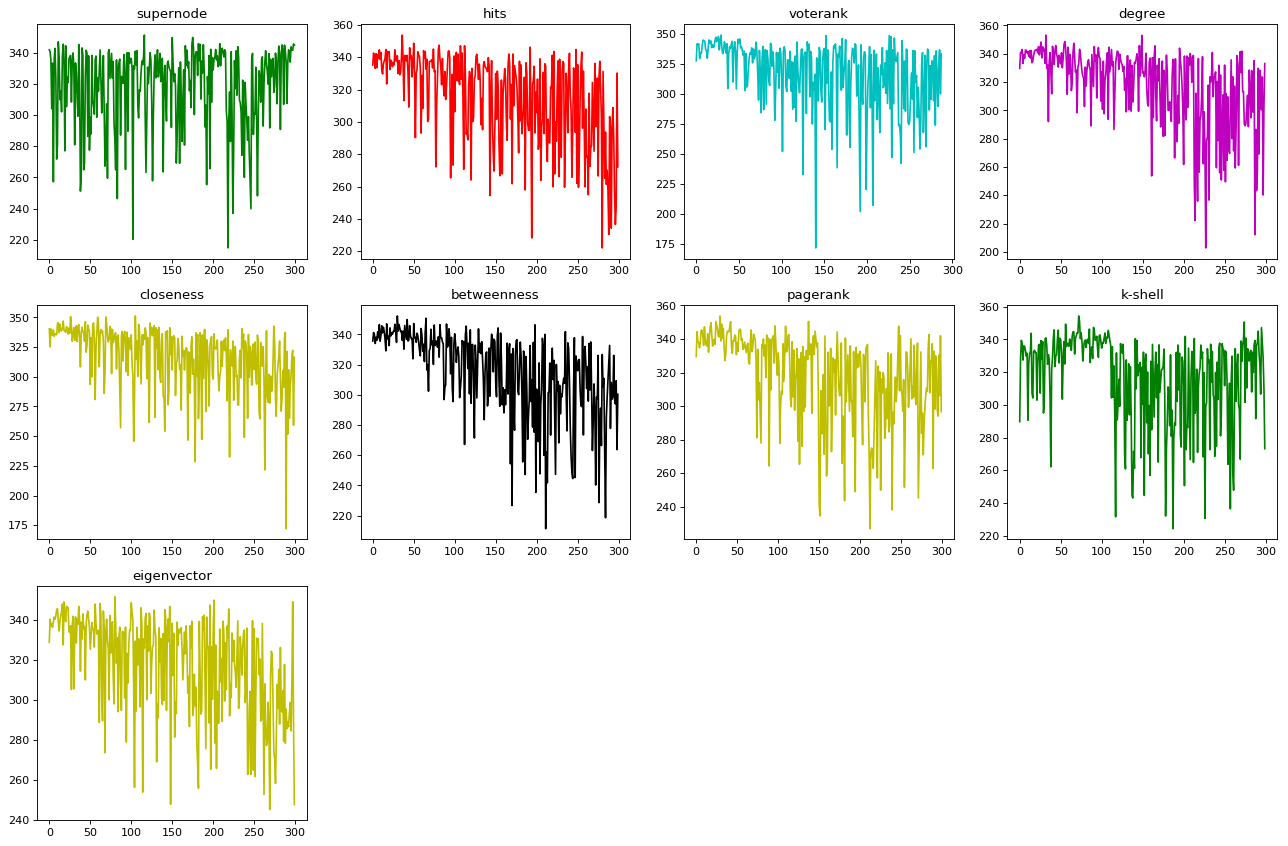

In [20]:
idx_counter = 1
colors = "bgrcmykygyb"
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
plt.subplots_adjust(top=1.5)
for method, nd_lab_scores in scores.items():
    sp = plt.subplot(840 + idx_counter)
    sp.plot(nd_lab_scores[1], colors[idx_counter])
    sp.set_title(method)
    idx_counter += 1
plt.show()